In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pickle
import torch
import astropy.units as u
import seaborn as sns
import pandas as pd

from typing import Tuple, Optional, Union
from itertools import cycle
from astropy.io import fits, ascii
from astropy.coordinates import SkyCoord, Angle, concatenate
from sklearn.model_selection import train_test_split
from neural_net import normalize_arr, get_model, CustomLoss, resume
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, LeaveOneOut
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score
from sklearn.impute import KNNImputer
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import StandardScaler

from preprocessing.preprocessing import ab_mag_to_flux

import matplotlib as mpl
plt.rc('text', usetex=True)

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cmr10'  # Computer Modern Roman
mpl.rcParams['font.size'] = 12  # Adjust the font size as needed

PATH_TO_CLEAN_DATA = '/Users/adamboesky/Research/ay98/clean_data'

# Clean the BTS SNe coordinates file for Panstarrs host association

In [2]:
bts_df = pd.read_csv('/Users/adamboesky/Research/ay98/clean_data/bts_sne.csv')
bts_df

,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V
0,ZTF17aaaeqms,AT2023jkf,01:19:13.43,+31:46:26.1,2102.97,r,17.5839,-,18.001,12.004,5.997,-,-,-30.726791,0.205
1,ZTF17aaajowi,-,11:47:44.37,+14:34:10.4,1362.73,r,18.9963,-,>5.611,2.651,>2.96,-,-,70.564727,0.127
2,ZTF17aaazdba,AT2019azh,08:13:16.95,+22:38:53.9,561.73,g,15.2769,-19.76,66.42,24.318,42.102,TDE,0.022,27.562336,0.122
3,ZTF17aabtvsy,SN2022yei,10:35:32.09,+37:38:59.0,1870.99,r,18.0303,-19.41,>34.229,>6.01,28.219,SN Ia,0.06922,59.641962,0.053
4,ZTF17aabwkio,AT2019sio,07:39:53.05,-02:58:50.6,765.01,g,18.1673,-,5.615,2.657,2.958,-,-,9.367699,0.306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7613,ZTF24aadryxf,AT2024bdy,08:11:39.37,-06:12:46.5,2341.84,g,18.9243,-,>18.07,>2.05,>16.02,-,-,14.717259,0.154
7614,ZTF24aaecshg,AT2024asp,10:27:12.30,+31:57:30.4,2341.85,g,18.9854,-,>12.96,>0,>12.96,-,-,58.406619,0.048
7615,ZTF24aaecxwe,AT2024bho,11:18:48.75,+78:04:57.2,2341.90,r,18.8290,-,>10.704,>0.12,10.584,-,-,37.961778,0.074
7616,ZTF24aaedncr,SN2005X,12:24:00.71,+07:46:39.2,2352.91,r,18.4054,-,>15.13,>11.06,>4.07,-,-,69.586749,0.069


In [3]:
ras = []
decs = []

for ra, dec in zip(bts_df['RA'], bts_df['Dec']):
    ra_ang = Angle(ra.split(',')[0], unit='hourangle')
    dec_ang = Angle(f'{dec.split(",")[0]} degrees')
    ras.append(ra_ang.degree)
    decs.append(dec_ang.degree)

In [4]:
bts_df['ra_deg'] = ras
bts_df['dec_deg'] = decs
bts_df

,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V,ra_deg,dec_deg
0,ZTF17aaaeqms,AT2023jkf,01:19:13.43,+31:46:26.1,2102.97,r,17.5839,-,18.001,12.004,5.997,-,-,-30.726791,0.205,19.805958,31.773917
1,ZTF17aaajowi,-,11:47:44.37,+14:34:10.4,1362.73,r,18.9963,-,>5.611,2.651,>2.96,-,-,70.564727,0.127,176.934875,14.569556
2,ZTF17aaazdba,AT2019azh,08:13:16.95,+22:38:53.9,561.73,g,15.2769,-19.76,66.42,24.318,42.102,TDE,0.022,27.562336,0.122,123.320625,22.648306
3,ZTF17aabtvsy,SN2022yei,10:35:32.09,+37:38:59.0,1870.99,r,18.0303,-19.41,>34.229,>6.01,28.219,SN Ia,0.06922,59.641962,0.053,158.883708,37.649722
4,ZTF17aabwkio,AT2019sio,07:39:53.05,-02:58:50.6,765.01,g,18.1673,-,5.615,2.657,2.958,-,-,9.367699,0.306,114.971042,-2.980722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7613,ZTF24aadryxf,AT2024bdy,08:11:39.37,-06:12:46.5,2341.84,g,18.9243,-,>18.07,>2.05,>16.02,-,-,14.717259,0.154,122.914042,-6.212917
7614,ZTF24aaecshg,AT2024asp,10:27:12.30,+31:57:30.4,2341.85,g,18.9854,-,>12.96,>0,>12.96,-,-,58.406619,0.048,156.801250,31.958444
7615,ZTF24aaecxwe,AT2024bho,11:18:48.75,+78:04:57.2,2341.90,r,18.8290,-,>10.704,>0.12,10.584,-,-,37.961778,0.074,169.703125,78.082556
7616,ZTF24aaedncr,SN2005X,12:24:00.71,+07:46:39.2,2352.91,r,18.4054,-,>15.13,>11.06,>4.07,-,-,69.586749,0.069,186.002958,7.777556


In [5]:
# Drop everything with no redshift
bts_clean_df = bts_df[bts_df['redshift'] != '-']
bts_clean_df = bts_clean_df[~pd.isnull(bts_clean_df['redshift'])]
bts_clean_df.reset_index(inplace=True, drop=True)
bts_clean_df

,ZTFID,IAUID,RA,Dec,peakt,peakfilt,peakmag,peakabs,duration,rise,fade,type,redshift,b,A_V,ra_deg,dec_deg
0,ZTF17aaazdba,AT2019azh,08:13:16.95,+22:38:53.9,561.73,g,15.2769,-19.76,66.42,24.318,42.102,TDE,0.022,27.562336,0.122,123.320625,22.648306
1,ZTF17aabtvsy,SN2022yei,10:35:32.09,+37:38:59.0,1870.99,r,18.0303,-19.41,>34.229,>6.01,28.219,SN Ia,0.06922,59.641962,0.053,158.883708,37.649722
2,ZTF17aacldgo,SN2022zxv,03:09:24.35,-04:53:39.2,1897.75,g,18.7979,-18.91,>8.87,>3.85,>5.02,SN Ia,0.072,-50.332472,0.183,47.351458,-4.894222
3,ZTF17aadlxmv,SN2020adv,08:29:47.59,+33:54:22.8,879.69,g,17.9475,-19.34,25.146,10.951,14.195,SN Ia,0.062,34.174702,0.106,127.448292,33.906333
4,ZTF18aaaibml,SN2020buc,10:08:31.27,+09:14:23.0,909.80,r,18.2606,-17.70,69.73,27.302,42.428,SN II,0.0348,47.637802,0.092,152.130292,9.239722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5337,ZTF24aaczgax,SN2024anc,10:58:15.99,+23:41:37.3,2341.77,g,17.2317,-17.64,19.703,10.28,9.423,SN II,0.02128,64.269422,0.046,164.566625,23.693694
5338,ZTF24aadauao,SN2024alp,01:59:32.67,+41:09:13.2,2340.62,g,17.8560,-19.40,>22.765,7.735,>15.03,SN Ia,0.05859,-19.917448,0.182,29.886125,41.153667
5339,ZTF24aadkwni,AT2024aul,10:21:53.23,+00:17:44.2,2339.81,r,17.5125,-17.44,>21.96,>3.89,>18.07,SN II,0.0215,45.192542,0.134,155.471792,0.295611
5340,ZTF24aadkwol,SN2024apt,10:25:36.87,-02:12:39.2,2354.83,g,15.4292,-19.23,31.42,17.427,13.993,SN Ia,0.01850,44.243280,0.124,156.403625,-2.210889


In [6]:
# Write to csv
bts_clean_df.to_csv('/Users/adamboesky/Research/ay98/clean_data/bts_sne_clean.csv')

# Load YSE and BTS data

In [7]:
# BTS
bts_hosts = ascii.read('/Users/adamboesky/Research/ay98/clean_data/bts_hosts.ecsv')
bts_df = bts_hosts.to_pandas()

# YSE
yse_hosts = ascii.read('/Users/adamboesky/Research/ay98/clean_data/yse_hosts.ecsv')
yse_df = yse_hosts.to_pandas()
print('BTS keys: ', bts_df.columns)
print('YSE keys: ', yse_df.columns)

BTS keys:  Index(['objID_3pi', 'raStack_3pi', 'decStack_3pi', 'primaryDetection_3pi',
       'gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi',
       'yKronMag_3pi', 'gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi',
       'zKronMagErr_3pi', 'yKronMagErr_3pi', 'ps_score_3pi', 'SN_ra', 'SN_dec',
       'sn_class', 'sn_redshift', 'ZTFID'],
      dtype='object')
YSE keys:  Index(['objID_3pi', 'raStack_3pi', 'decStack_3pi', 'primaryDetection_3pi',
       'gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi',
       'yKronMag_3pi', 'gKronMagErr_3pi', 'rKronMagErr_3pi', 'iKronMagErr_3pi',
       'zKronMagErr_3pi', 'yKronMagErr_3pi', 'ps_score_3pi', 'SN_ra', 'SN_dec',
       'sn_class', 'sn_redshift'],
      dtype='object')


In [79]:
# yse_hosts['gKronMagErr_3pi'][np.array(yse_hosts['gKronMagErr_3pi']).astype(float) == 0]
np.isnan(np.array(yse_hosts['gKronMagErr_3pi']).astype(float)),np.sum(np.isnan(np.array(yse_hosts['gKronMagErr_3pi']).astype(float))) / len(yse_hosts)

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False,
      

In [8]:
def propocess_tab(table: ascii.Tab) -> pd.DataFrame:

    # Make and format a pd dataframe
    df: pd.DataFrame = table.to_pandas()
    column_types = {col: float for col in df.columns[:-2]}
    column_types[df.columns[-2]] = str
    column_types[df.columns[-1]] = float
    df = df.astype(column_types)
    df.replace('nan', np.nan, inplace=True)

    # The columns of grizy mags
    sed_cols = ['gKronMag_3pi','rKronMag_3pi','iKronMag_3pi','zKronMag_3pi','yKronMag_3pi']

    # Drop rows where the specified columns have more than 4 NaN values
    orig_len = len(df)
    df = df.dropna(thresh=3, subset=sed_cols, ignore_index=True)
    df = df.dropna(subset=['sn_class'], ignore_index=True)
    print(f'Dropped {orig_len - len(df)}/{orig_len} rows due to missingness. Now have {len(df)}')

    # Function to calculate angular separation
    def angular_separation(ra1, dec1, ra2, dec2):
        coord1 = SkyCoord(ra1, dec1, unit='deg')
        coord2 = SkyCoord(ra2, dec2, unit='deg')
        return coord1.separation(coord2).arcsec

    # Apply the function to each row
    df['angular_separation_arcsec'] = df.apply(lambda row: angular_separation(row['raStack_3pi'], row['decStack_3pi'], row['SN_ra'], row['SN_dec']), axis=1)

    return df

In [41]:
types_all = pd.concat((bts_df['sn_class'], yse_df['sn_class'])).astype(str)
sn_mask = np.array(['sn' in item.lower() for item in types_all.astype(str)])
np.unique(types_all[mask])

array(['SLSN-I', 'SLSN-II', 'SN II', 'SN II-pec', 'SN IIP', 'SN IIb',
       'SN IIn', 'SN Ia', 'SN Ia-91T', 'SN Ia-91bg', 'SN Ia-CSM',
       'SN Ia-SC', 'SN Ia-pec', 'SN Iax', 'SN Ib', 'SN Ib-pec', 'SN Ib/c',
       'SN Ibn', 'SN Ic', 'SN Ic-BL', 'SN Ic-pec', 'SN Icn', 'SNII',
       'SNIIb', 'SNIIn', 'SNIa-91T-like', 'SNIa-91bg-like', 'SNIa-CSM',
       'SNIa-SC', 'SNIa-norm', 'SNIax', 'SNIb', 'SNIb-pec', 'SNIbn',
       'SNIc', 'SNIc-BL'], dtype=object)

In [42]:
# Compile all data into one array
grizy_keys = ['gKronMag_3pi', 'rKronMag_3pi', 'iKronMag_3pi', 'zKronMag_3pi', 'yKronMag_3pi']
X_all = pd.concat((bts_df[grizy_keys], yse_df[grizy_keys])).astype(float)
z_all = pd.concat((bts_df['sn_redshift'], yse_df['sn_redshift'])).astype(float)

# Drop all the rows where we don't have at least 3 grizy bands
bad_rows_mask = X_all.isnull().sum(axis=1) >= 1
good_rows_mask = (~bad_rows_mask) & sn_mask
X_all = X_all[good_rows_mask].to_numpy()
z_all = z_all[good_rows_mask].to_numpy()
types_all = types_all[good_rows_mask].to_numpy()

# Drop all rows where we have no redshift value
has_no_z_mask = np.isnan(z_all)
X_all = X_all[~has_no_z_mask]
z_all = z_all[~has_no_z_mask]
types_all = types_all[~has_no_z_mask]

# Convert grizy from mag to flux and take the log
X_all = ab_mag_to_flux(X_all)
imputer = KNNImputer(n_neighbors=5)
X_all = imputer.fit_transform(X_all)
X_all = np.log10(X_all)

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_83185/2979282976.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(z_all, bins=50)


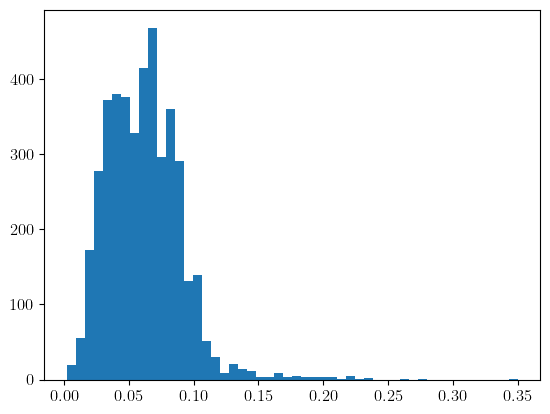

In [43]:
plt.hist(z_all, bins=50)
plt.show()

Normalize the data

In [44]:
def normalize_arr(arr: np.ndarray, errors: np.ndarray = None, axis: int = 0, mean: float = None, std: float = None) -> (float, float, float, Optional[np.ndarray]):
    """Normalize numpy array along given axis and its errors if given."""
    if mean is None:
        mean = np.mean(arr, axis=axis, keepdims=True)
    if std is None:
        std = np.std(arr, axis=axis, keepdims=True)
    if not errors is None:
        return (arr - mean) / std, mean[0], std[0], errors / std
    else:
        return (arr - mean) / std, mean, std

In [54]:
# Get the mean and std of the training set
from sed_nn import load_and_preprocess
_, _, _, _, _, _, _, _, _, photo_mean, photo_std, photo_err_norm = load_and_preprocess()

# Call the yse and bts data
X_all_norm, X_mean, X_std = normalize_arr(X_all, mean=photo_mean[:5], std=photo_std[:5])

within_good_range = np.all((X_all_norm < 4) & (X_all_norm > -4), axis=1)
# within_good_range = np.array([True for _ in range(len(z_all))])
X_all_norm, z_all = X_all_norm[within_good_range], z_all[within_good_range]

2024-03-04 18:06:27,022 - sed_nn.py - INFO - Importing photometry data
2024-03-04 18:06:29,002 - sed_nn.py - INFO - Fixing the error for 96514 objects
2024-03-04 18:06:29,013 - sed_nn.py - INFO - Importing photometry data
2024-03-04 18:06:30,743 - sed_nn.py - INFO - Photo stats:
 	mean = [-2.88750664 -2.80485236 -2.79177703 -2.64890962 -2.69422682 -1.33202668
  0.06717019  0.67723176  1.35547094  0.92884049  1.34127727  1.21686633
  1.33390055 -2.42786271 -2.2128036  -1.99193711 -3.04366902 -3.0434582 ]
 	std = [0.6256189  0.69351311 0.67564669 0.71696901 0.78423232 0.88506622
 1.62868632 2.06807325 0.43284611 1.35729201 0.49397298 0.43336611
 0.45556757 2.21415807 2.12945886 2.02186998 0.66726908 0.69343955]
2024-03-04 18:06:30,744 - sed_nn.py - INFO - Catalog stats:
 	mean = [[ 8.69840122 -0.65829206  0.56184221]]
 	std = [[1.31209275 1.35189867 0.29137484]]
2024-03-04 18:06:30,745 - sed_nn.py - INFO - Length = 1261630


HEEERRRREE [[ 0.70927392  1.25512957  0.2270539 ]
 [-0.33256743  0.67634887  0.87570289]
 [-0.2748967   0.76784266  0.57368643]
 ...
 [ 0.60130756 -0.66104664  0.7521507 ]
 [-1.06907597 -0.30847975 -0.19851475]
 [-0.32610561 -0.29959755 -0.82657171]]
[[ 8.69840122 -0.65829206  0.56184221]]


2024-03-04 18:06:31,856 - sed_nn.py - INFO - Splitting into:
	X = ['G', 'R', 'I', 'Z', 'Y']
	y = ['J', 'H', 'Ks', 'CH1', 'CH2', 'MIPS24', 'MIPS70', 'PACS100', 'MIPS160', 'PACS160', 'SPIRE250', 'SPIRE350', 'SPIRE500']


In [55]:
# Also grab the means and std of the host properties
from host_prop_nn import load_and_preprocess

# Scale the properties by the Zou mean and std for later
test, _, _, _, _, _, _, _, _, _, _, _, _, _, _, prop_mean, prop_std, _ = load_and_preprocess()

2024-03-04 18:06:32,068 - host_prop_nn.py - INFO - Importing photometry data
2024-03-04 18:06:34,075 - host_prop_nn.py - INFO - Fixing the error for 96514 objects
2024-03-04 18:06:34,086 - host_prop_nn.py - INFO - Importing photometry data
2024-03-04 18:06:35,896 - host_prop_nn.py - INFO - Photo stats:
 	mean = [-2.88750664 -2.80485236 -2.79177703 -2.64890962 -2.69422682 -1.33202668
  0.06717019  0.67723176  1.35547094  0.92884049  1.34127727  1.21686633
  1.33390055 -2.42786271 -2.2128036  -1.99193711 -3.04366902 -3.0434582 ]
 	std = [0.6256189  0.69351311 0.67564669 0.71696901 0.78423232 0.88506622
 1.62868632 2.06807325 0.43284611 1.35729201 0.49397298 0.43336611
 0.45556757 2.21415807 2.12945886 2.02186998 0.66726908 0.69343955]
2024-03-04 18:06:35,897 - host_prop_nn.py - INFO - Catalog stats:
 	mean = [ 8.69840122 -0.65829206  0.56184221]
 	std = [1.31209275 1.35189867 0.29137484]
2024-03-04 18:06:35,899 - host_prop_nn.py - INFO - Length = 1261630


HEEERRRREE [[ 0.70927392  1.25512957  0.2270539 ]
 [-0.33256743  0.67634887  0.87570289]
 [-0.2748967   0.76784266  0.57368643]
 ...
 [ 0.60130756 -0.66104664  0.7521507 ]
 [-1.06907597 -0.30847975 -0.19851475]
 [-0.32610561 -0.29959755 -0.82657171]]
[ 8.69840122 -0.65829206  0.56184221]


# Domain transfer and infer host properties

In [56]:
# Training parameters
nodes_per_layer = [7, 9, 11, 13]
num_linear_output_layers = 1
torch.set_default_dtype(torch.float64)
sed_model = get_model(num_inputs=5, num_outputs=13, nodes_per_layer=nodes_per_layer, num_linear_output_layers=num_linear_output_layers)

# Load best model
resume(sed_model, '/Users/adamboesky/Research/ay98/Weird_Galaxies/best_sed_model.pkl')
sed_model.eval()

Sequential(
  (input): Linear(in_features=5, out_features=7, bias=True)
  (act_input): ReLU()
  (layer_0): Linear(in_features=7, out_features=9, bias=True)
  (act_0): ReLU()
  (layer_1): Linear(in_features=9, out_features=11, bias=True)
  (act_1): ReLU()
  (layer_2): Linear(in_features=11, out_features=13, bias=True)
  (act_2): ReLU()
  (output): Linear(in_features=13, out_features=13, bias=True)
)

In [57]:
# Predict the remainder of the SED
sed_preds = sed_model(torch.from_numpy(X_all_norm)).detach().numpy()
X_all_norm_full = np.hstack((X_all_norm, sed_preds))  # note that this is still scaled to be input into the host prop NN

In [58]:
# Load the property-predicting model
n_epochs = 1000
nodes_per_layer = [18, 15, 12, 9, 6, 4]
num_linear_output_layers = 3
learning_rate = 0.01
batch_size = 4096
torch.set_default_dtype(torch.float64)
prop_model = get_model(num_inputs=18, num_outputs=3, nodes_per_layer=nodes_per_layer, num_linear_output_layers=num_linear_output_layers)
loss_fn = CustomLoss()
optimizer = torch.optim.AdamW(prop_model.parameters(), lr=learning_rate)
resume(prop_model, '/Users/adamboesky/Research/ay98/Weird_Galaxies/best_model.pkl')
prop_model.eval()

Sequential(
  (input): Linear(in_features=18, out_features=18, bias=True)
  (act_input): ReLU()
  (layer_0): Linear(in_features=18, out_features=15, bias=True)
  (act_0): ReLU()
  (layer_1): Linear(in_features=15, out_features=12, bias=True)
  (act_1): ReLU()
  (layer_2): Linear(in_features=12, out_features=9, bias=True)
  (act_2): ReLU()
  (layer_3): Linear(in_features=9, out_features=6, bias=True)
  (act_3): ReLU()
  (layer_4): Linear(in_features=6, out_features=4, bias=True)
  (act_4): ReLU()
  (pre_output0): Linear(in_features=4, out_features=4, bias=True)
  (pre_output1): Linear(in_features=4, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=3, bias=True)
)

In [59]:
# Predict the host properties
props_pred = prop_model(torch.from_numpy(X_all_norm_full)).detach().numpy()
props_pred = props_pred * prop_std + prop_mean
z_pred = props_pred[:, -1]

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_83185/2848507711.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.hist(z_pred, bins=50, alpha=0.5, label='pred')


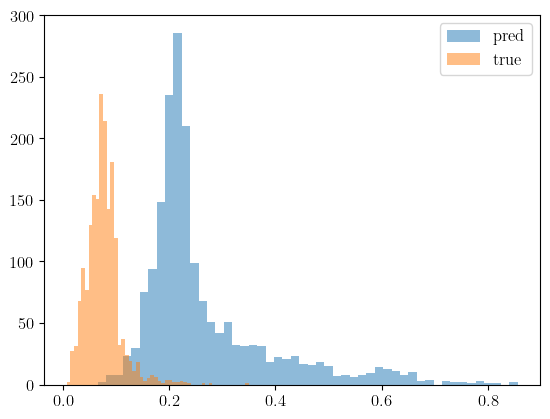

In [60]:
plt.hist(z_pred, bins=50, alpha=0.5, label='pred')
plt.hist(z_all, bins=50, alpha=0.5, label='true')
plt.legend()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_83185/3398513432.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.scatter(z_all, z_pred, s=5)


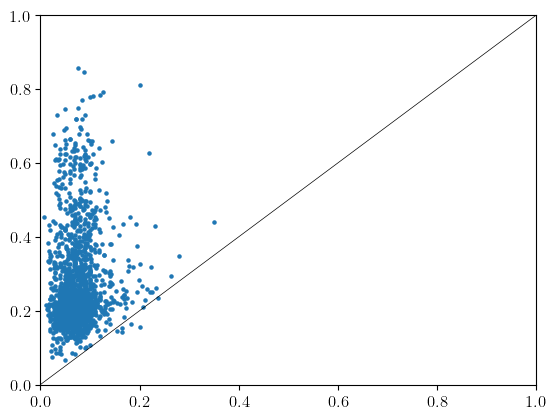

In [61]:
plt.scatter(z_all, z_pred, s=5)
plt.axline((0, 0), slope=1, color='black', linewidth=0.5)
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_83185/899694179.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(1,1, figsize=(5, 5))
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_83185/899694179.py:7: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
/var/folders/2f/vnb6fr7n7g32fwlgp_k3l3sc0000gn/T/ipykernel_83185/899694179.py:17: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)


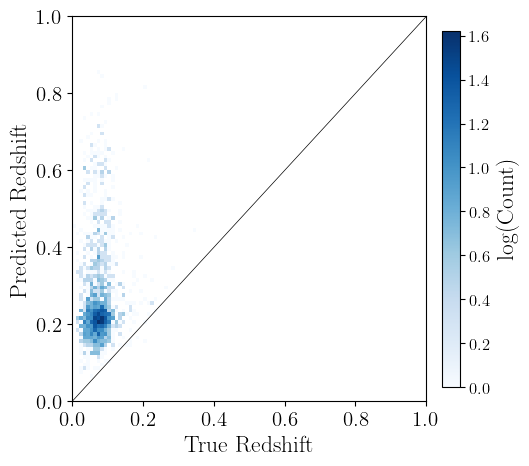

In [62]:
# Real v pred heatmap
fig, ax = plt.subplots(1,1, figsize=(5, 5))

# Plot
heatmap, xedges, yedges = np.histogram2d(z_all, z_pred, bins=(100, 100), range=[(0,1), (0,1)])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = ax.imshow(np.log10(heatmap).T, origin='lower', aspect='auto', cmap='Blues', extent=extent)
ax.axline((0, 0), slope=1, color='black', linewidth=0.5)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel(r'True Redshift', fontsize=17)
ax.set_ylabel(r'Predicted Redshift', fontsize=17)
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a colorbar
# cbar_ax = fig.add_axes([0.92, 0.53, 0.02, 0.1])  # Adjust the position and size as needed
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label(r'$\log(\rm{Count})$', fontsize=17)  # Adjust fontsize as needed
# plt.tight_layout()
# plt.savefig('/Users/adamboesky/Research/ay98/Weird_Galaxies/Figures/host_prop_real_v_preds.pdf', bbox_inches='tight')
plt.show()